Connect to GitHub

In [2]:
from getpass import getpass
token = getpass("Enter your GitHub Personal Access Token:")

!pip install git+https://{token}@github.com/neuroprismlab/_MUA_Pipeline.git

Enter your GitHub Personal Access Token:··········
  Cloning https://****@github.com/neuroprismlab/_MUA_Pipeline.git to /tmp/pip-req-build-70b7mhn2
  Running command git clone --filter=blob:none --quiet 'https://****@github.com/neuroprismlab/_MUA_Pipeline.git' /tmp/pip-req-build-70b7mhn2
  Resolved https://****@github.com/neuroprismlab/_MUA_Pipeline.git to commit 51b8a090df3f8e5435b3dc125fab5f5e37eb081c
  Preparing metadata (setup.py) ... done
  Created wheel for mua-pipeline: filename=mua_pipeline-0.1.0-py3-none-any.whl size=17881 sha256=4aea7eb153fd08e78f245eb82ab6d1c3cbc57d7534b17c219251ca9618a1b2ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-fds3wr6f/wheels/cb/42/68/794ba24fc5d728836388507ceeeda5049e093eb3ca0a9de5ff
Successfully built mua-pipeline


Verify the installation

In [3]:
from mua_pipeline import FeatureVectorizer, MUA, preprocess, plot_results
print("MUA Pipeline installed successfully!")

MUA Pipeline installed successfully!


Other imports

In [4]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

Create toy data

In [6]:
n_subjects = 1000
n_regions = 200

np.random.seed(42)
connectivity_matrices = np.random.randn(n_subjects, n_regions, n_regions)

for i in range(n_subjects):
    connectivity_matrices[i] = (connectivity_matrices[i] + connectivity_matrices[i].T) / 2
    np.fill_diagonal(connectivity_matrices[i], 1.0)

behavioral_measures = np.random.randn(n_subjects) * 10 + 100

print(f"Data created: {connectivity_matrices.shape} connectivity, {behavioral_measures.shape} behavioral")


Data created: (1000, 200, 200) connectivity, (1000,) behavioral


Preprocessing

In [7]:
clean_conn, clean_behav, removed = preprocess(
    connectivity_matrices,
    behavioral_scores,
    missing_strategy='any',
    verbose=True
)

No subjects with missing data found.


Settings

In [8]:
cv = 10

CPM Pipeline

Original CPM
CPM R2 (10-fold CV): -0.082 +/- 0.077
Correlation: r=0.079, p=1.30e-02
R2: -0.066
MAE: 8.549
RMSE: 10.646


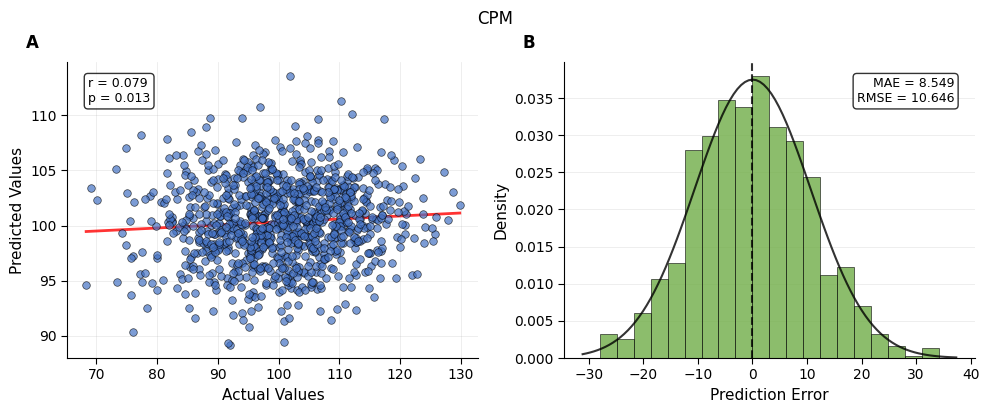

In [11]:
print("Original CPM")

cpm_pipeline = Pipeline([
    ('vectorize', FeatureVectorizer()),
    ('mua', MUA(
        filter_by_sign=True,
        direction='difference',
        selection_method='pvalue',
        selection_threshold=0.05,
        weighting_method='binary',
        feature_aggregation='mean',
    )),
    ('regressor', LinearRegression())
])

cpm_scores = cross_val_score(cpm_pipeline, clean_conn, clean_behav, cv=cv)
cpm_predictions = cross_val_predict(cpm_pipeline, clean_conn, clean_behav, cv=cv)

print(f"CPM R2 ({cv}-fold CV): {cpm_scores.mean():.3f} +/- {cpm_scores.std():.3f}")

cpm_r, cpm_p = pearsonr(clean_behav, cpm_predictions)
print(f"Correlation: r={cpm_r:.3f}, p={cpm_p:.2e}")
print(f"R2: {r2_score(clean_behav, cpm_predictions):.3f}")
print(f"MAE: {mean_absolute_error(clean_behav, cpm_predictions):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(clean_behav, cpm_predictions)):.3f}")

plot_results(cpm_predictions, clean_behav, title="CPM")

PNRS Pipeline

PNRS
PNRS scores shape: (1000, 1)
Correlation: r=0.454, p=3.99e-52


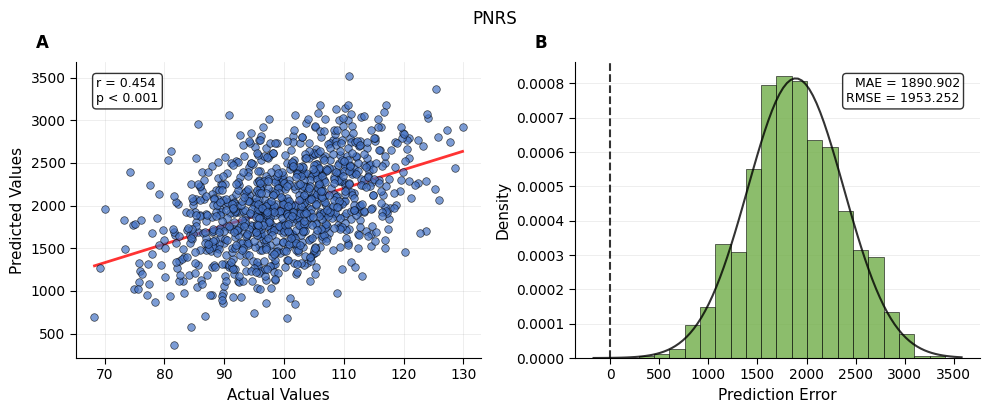

In [14]:
print("PNRS")

pnrs_pipeline = Pipeline([
    ('vectorize', FeatureVectorizer()),
    ('mua', MUA(
        filter_by_sign=False,
        selection_method='all',
        weighting_method='regression',
        feature_aggregation='sum',
    ))
])

pnrs_scores = pnrs_pipeline.fit_transform(clean_conn, clean_behav)
pnrs_predictions = pnrs_scores.flatten()

pnrs_r, pnrs_p = pearsonr(clean_behav, pnrs_predictions)
print(f"PNRS scores shape: {pnrs_scores.shape}")
print(f"Correlation: r={pnrs_r:.3f}, p={pnrs_p:.2e}")

plot_results(pnrs_predictions, clean_behav, title="PNRS")